In [23]:
import sys
import os
sys.path.append(os.path.join(os.path.dirname(os.getcwd())))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from estimators.DependentBootstrapSampling import DependentBootstrapSampling

plt.style.use('ggplot')

In [24]:
import numpy as np

def simulate_stationary_var(p, k, n):
    # Check if the generated coefficients are for a stationary process
    def is_stationary(coeffs):
        comp_matrix = np.zeros((k * p, k * p))
        for i, coeff in enumerate(coeffs):
            comp_matrix[:k, k * i:k * (i + 1)] = coeff
        comp_matrix[k:, :k * (p - 1)] = np.eye(k * (p - 1))
        eigenvalues = np.abs(np.linalg.eigvals(comp_matrix))
        return np.all(eigenvalues < 1)

    # Initialize the array to store the time series
    time_series = np.zeros((n, k))
    
    # Initialize coefficients
    coefficients = []

    # Generate random coefficients and check for stationarity
    while len(coefficients) < p or not is_stationary(coefficients):
        coefficients = [np.random.uniform(-0.5, 0.5, (k, k)) for _ in range(p)]

    # Generate initial values
    for i in range(p):
        time_series[i, :] = np.random.randn(k)

    # Generate the time series
    for t in range(p, n):
        for lag in range(p):
            time_series[t] += time_series[t - lag - 1].dot(coefficients[lag])
        # Add some noise
        time_series[t] += np.random.randn(k)

    return time_series


## Simulate VAR process

<Axes: >

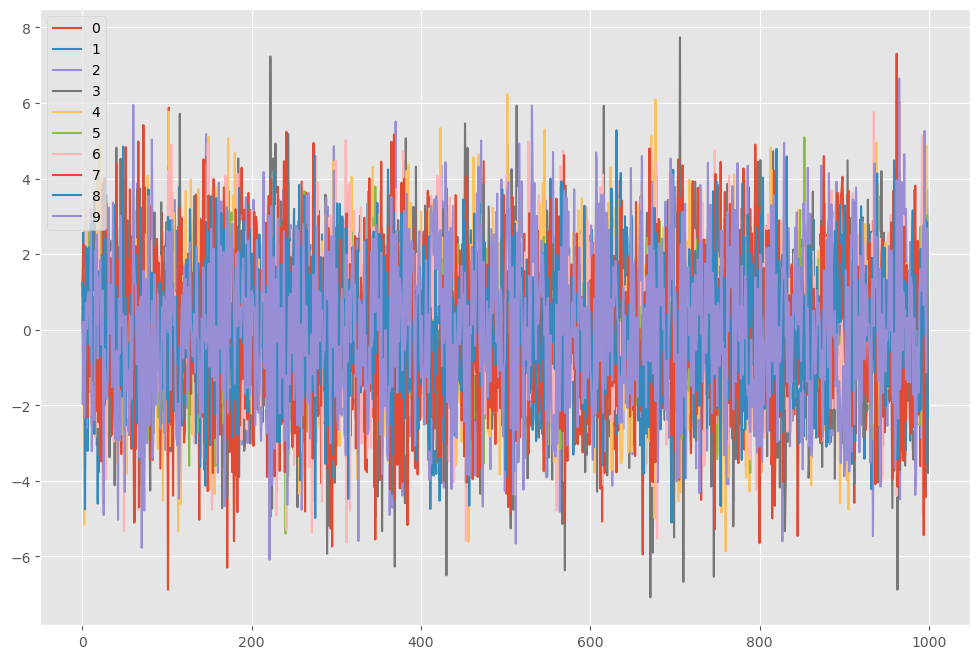

In [25]:
x = simulate_stationary_var(p=1, k=10, n=1000)

pd.DataFrame(x).plot(figsize=(12, 8))

## Compute correlation an covariance of the original process

<Axes: title={'center': 'Correlation matrix of the original data'}>

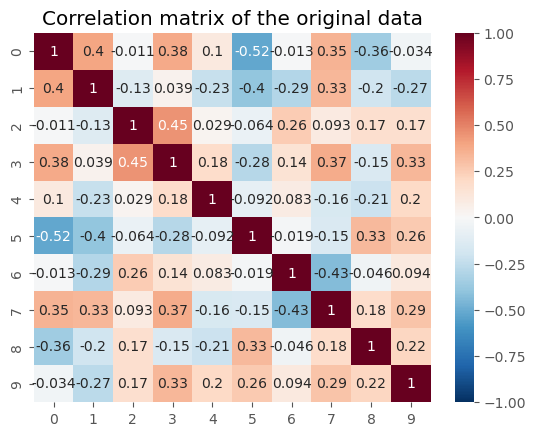

In [45]:
corr_original = pd.DataFrame(x).corr()

plt.title("Correlation matrix of the original data")
sns.heatmap(corr_original, annot=True, cmap='RdBu_r', vmin=-1, vmax=1)

<Axes: title={'center': 'Covariance matrix of the original data'}>

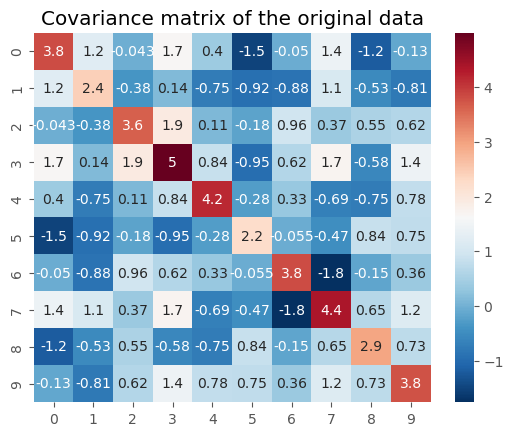

In [46]:
cov_original = pd.DataFrame(x).cov()

plt.title("Covariance matrix of the original data")
sns.heatmap(cov_original, annot=True, cmap='RdBu_r')

## Resample VAR process

In [28]:
x_tensor = torch.tensor(x, dtype=torch.float32)

dependent_boot = DependentBootstrapSampling(time_series=x_tensor,
                                            boot_method="cbb",
                                             Bsize=100)

In [33]:
# first block
dependent_boot.Blocks[0].shape

torch.Size([100, 10])

<Axes: title={'center': 'Correlation matrix of the first block'}>

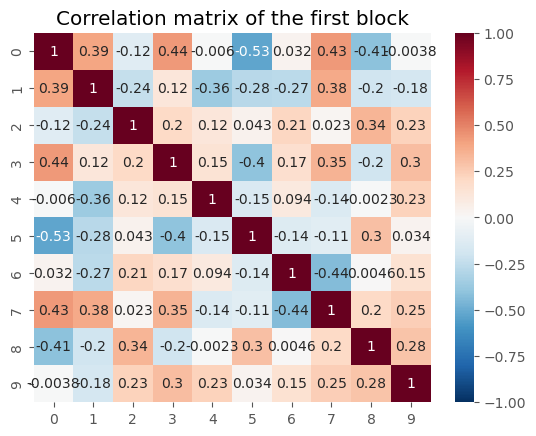

In [44]:
boot_corr = pd.DataFrame(dependent_boot.Blocks[0].numpy()).corr()

plt.title("Correlation matrix of the first block")
sns.heatmap(boot_corr, annot=True, cmap='RdBu_r', vmin=-1, vmax=1)

<Axes: title={'center': 'Covariance matrix of the first block'}>

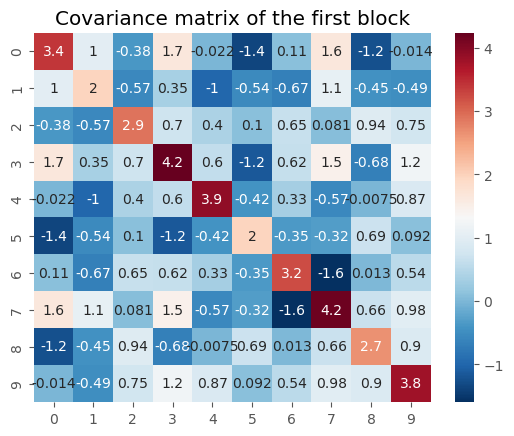

In [47]:
boot_cov = pd.DataFrame(dependent_boot.Blocks[0].numpy()).cov()

plt.title("Covariance matrix of the first block")
sns.heatmap(boot_cov, annot=True, cmap='RdBu_r')